In [16]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.stattools as sts 
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from keras.layers import LSTM,Dense,SimpleRNN,Conv1D,MaxPooling1D,Flatten , Dropout
from sklearn.svm import SVR 
import import_ipynb
import Forecasting_ML as ml

(-5.952529884175584, 2.1304602740344752e-07, 20, 648, {'1%': -3.4404817800778034, '5%': -2.866010569916275, '10%': -2.569150763698369}, 13942.462488106881)


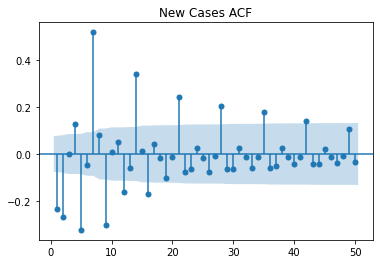

In [17]:
#------------------------------------(Read Dataset)-------------------------------------------

df=pd.read_csv("C:/Users/Asus/Desktop/Forecasting-covidcases/dataset-fr.csv")
df['date']=pd.to_datetime(df['date']).dt.date
df.set_index('date',inplace=True)


#------------------------------(verify stationary)--------------------------------------------
#for checking stationary just for column that wanna to predict it
df_diff=df.conf_j1.diff().dropna()
print(sts.adfuller(df_diff))
plot_acf(df_diff,lags=50,zero=False)
plt.title('New Cases ACF')
plt.show()

In [18]:
#------------------(Split Dataset)---------------------------------------------

TRAIN_SPLIT=int(len(df)*0.8)
#print(TRAIN_SPLIT)
lag=21 #for active cases (conf_j1)
#------------------(convert to supervised)-------------------------------------
#------------------(Multivariate_data function)--------------------------------
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)
#------------------------(set variable and convert to supervised)--------------
#the function just accept the array type
df=np.array(df)

In [19]:
#----------------------------(Scale Data)--------------------------------------
scaler =MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(df)

past_history =lag
#number of step for prediction
future_target = 3
STEP = 1

x_train_multi, y_train_multi= multivariate_data(df, df[:,12], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=False)
x_test_multi, y_test_multi = multivariate_data(df, df[:,12],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=False)

print(x_train_multi.shape ,x_test_multi.shape ,y_train_multi.shape,y_test_multi.shape)



#------------------(define models and fit)-------------------------------------

#-------------------(Simple RNN)-----------------------------------------------

RNN_model = Sequential()
RNN_model.add(SimpleRNN(50,input_shape=x_train_multi.shape[-2:],activation='relu',return_sequences=True ))
#RNN_model.add(Dropout(0.3))
RNN_model.add(SimpleRNN(50,activation='relu',kernel_regularizer='l2'))
RNN_model.add(Dropout(0.3))
RNN_model.add(Dense(future_target,activation='selu'))
RNN_model.compile(optimizer='adam', loss='mse')
history_RNN=RNN_model.fit(x_train_multi,y_train_multi,epochs=100,batch_size=16,validation_data=(x_test_multi,y_test_multi),shuffle=False)

(515, 21, 15) (110, 21, 15) (515, 3) (110, 3)
Epoch 1/100
33/33 [==============================] - 2s 16ms/step - loss: 0.4813 - val_loss: 0.4555
Epoch 2/100
33/33 [==============================] - 0s 7ms/step - loss: 0.3269 - val_loss: 0.3346
Epoch 3/100
33/33 [==============================] - 0s 7ms/step - loss: 0.2334 - val_loss: 0.2575
Epoch 4/100
33/33 [==============================] - 0s 7ms/step - loss: 0.1682 - val_loss: 0.2093
Epoch 5/100
33/33 [==============================] - 0s 7ms/step - loss: 0.1213 - val_loss: 0.1718
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0885 - val_loss: 0.1437
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0653 - val_loss: 0.1262
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0489 - val_loss: 0.1121
Epoch 9/100
33/33 [==============================] - 0s 8ms/step - loss: 0.0372 - val_loss: 0.1022
Epoch 10/100
33/33 [==============================] - 0s 8ms/s

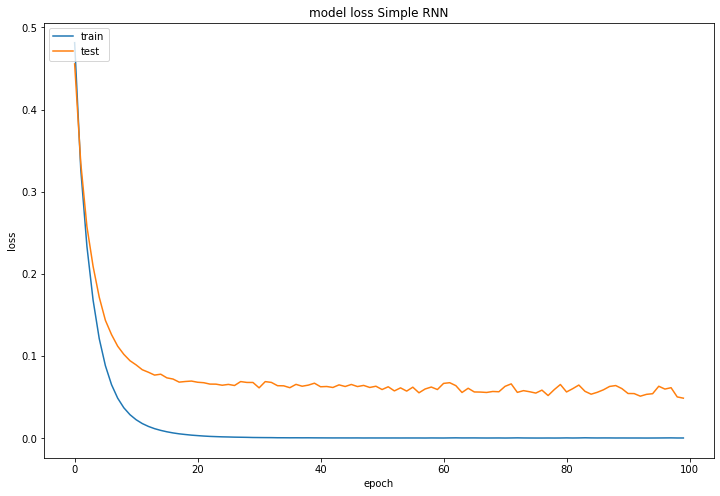

MSE_RNN :  0.048847816437907844
Next step RNN : 
 [[0.21822283 0.22913983 0.19432876]]


In [20]:
#------------------------------(learning curve)--------------------------------
plt.figure(figsize=(12,8))
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.title('model loss Simple RNN')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#------------------(MSE and Predict)-------------------------------------------
##Predict Test Set
predict_RNN=RNN_model.predict(x_test_multi)
#print(predict_RNN.shape)
mse_RNN= mean_squared_error(y_test_multi, predict_RNN)
print("MSE_RNN : ",  mse_RNN)

##-------------------(predict next step)---------------------------------------
input_samples=x_test_multi[-1:,:,:]
next_step_RNN=RNN_model.predict(input_samples)
#print(next_step_RNN.shape)
print("Next step RNN : \n" , next_step_RNN)

Epoch 1/100
33/33 [==============================] - 4s 38ms/step - loss: 1.4046 - val_loss: 1.0342
Epoch 2/100
33/33 [==============================] - 1s 20ms/step - loss: 0.6885 - val_loss: 0.5300
Epoch 3/100
33/33 [==============================] - 1s 20ms/step - loss: 0.3181 - val_loss: 0.2794
Epoch 4/100
33/33 [==============================] - 1s 20ms/step - loss: 0.1387 - val_loss: 0.1629
Epoch 5/100
33/33 [==============================] - 1s 20ms/step - loss: 0.0569 - val_loss: 0.1121
Epoch 6/100
33/33 [==============================] - 1s 22ms/step - loss: 0.0221 - val_loss: 0.0906
Epoch 7/100
33/33 [==============================] - 1s 25ms/step - loss: 0.0083 - val_loss: 0.0834
Epoch 8/100
33/33 [==============================] - 1s 23ms/step - loss: 0.0033 - val_loss: 0.0802
Epoch 9/100
33/33 [==============================] - 1s 26ms/step - loss: 0.0016 - val_loss: 0.0795
Epoch 10/100
33/33 [==============================] - 1s 22ms/step - loss: 0.0011 - val_loss: 0.0791

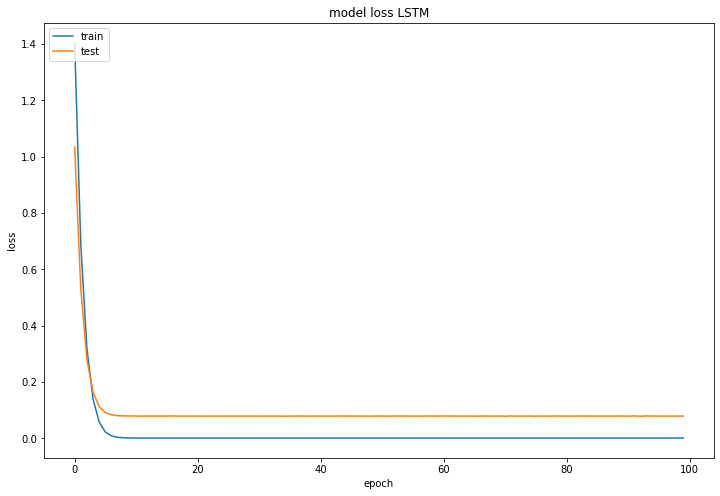

MSE_LSTM :  0.07884444550751141
Next step LSTM : 
 [[0.04148718 0.04214454 0.0408341 ]]


In [21]:
#---------------------(LSTM)---------------------------------------------------
LSTM_model = Sequential()
LSTM_model.add(LSTM(50,input_shape=x_train_multi.shape[-2:],activation='relu',return_sequences=True,kernel_regularizer='l2'))
LSTM_model.add(Dropout(0.3))
LSTM_model.add(LSTM(50,activation='relu',kernel_regularizer='l2',return_sequences=True))
LSTM_model.add(Dropout(0.3))
LSTM_model.add(LSTM(50,activation='relu',kernel_regularizer='l2'))
LSTM_model.add(Dropout(0.3))
LSTM_model.add(Dense(future_target,activation='selu'))
LSTM_model.compile(optimizer='adam', loss='mse')
history_LSTM=LSTM_model.fit(x_train_multi,y_train_multi,epochs=100,batch_size=16,validation_data=(x_test_multi,y_test_multi))
#------------------------------(learning curve)--------------------------------
plt.figure(figsize=(12,8))
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('model loss LSTM')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#------------------(MSE and Predict)-------------------------------------------
##Predict Test Set
predict_LSTM=LSTM_model.predict(x_test_multi)
mse_LSTM= mean_squared_error(y_test_multi, predict_LSTM)
print("MSE_LSTM : ",  mse_LSTM)
##-------------------(predict next step)---------------------------------------
input_samples=x_test_multi[-1:,:,:]
next_step_LSTM=LSTM_model.predict(input_samples)
#print(next_step_RNN.shape)
print("Next step LSTM : \n" , next_step_LSTM)

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

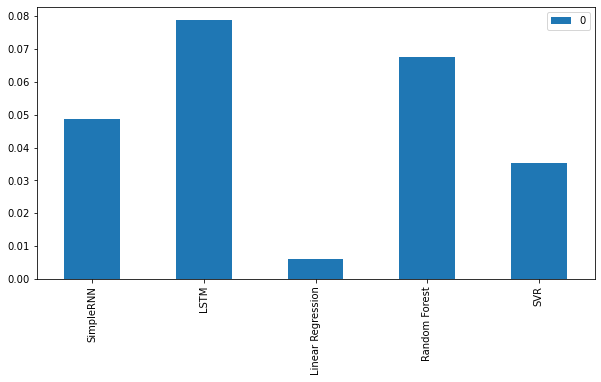

In [22]:
#----------------------(import ML results)-------------------------------------
mse_RF=ml.mse_RF
mse_LR=ml.mse_LR
mse_SVR=ml.mse_SVR

result={'SimpleRNN':mse_RNN,'LSTM':mse_LSTM, "Linear Regression":mse_LR ,"Random Forest":mse_RF , "SVR":mse_SVR }
result=pd.DataFrame.from_dict(result,orient='index')
plt.suptitle('Result')
result.plot(kind='bar',figsize=(10,5))
